In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]
# len(words)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
# build the vocabuary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i +1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [10]:
block_size = 8 # context length: how many characters do we take to predict the next one?
def build_dataset(words):
    
    X, Y = [], []

    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
    

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [11]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> e
.......e ---> b
......eb ---> r
.....ebr ---> i
....ebri ---> m
...ebrim ---> a
..ebrima ---> .
........ ---> h
.......h ---> i
......hi ---> l
.....hil ---> t
....hilt ---> o
...hilto ---> n
..hilton ---> .
........ ---> j
.......j ---> h
......jh ---> e
.....jhe ---> n
....jhen ---> e
...jhene ---> .


In [12]:
# let us train  a deeper network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentun update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        # adjust the dimenionality of the x.mean
        if self.training:
            if x.ndim == 2:
            # if the data has two dimensions reduce the dimension to 0
                dim = 0
            elif x.ndim == 3:
            # if the data has three dimensions reduce the dimension to 1
            # i previously had a dim bug here; 
            # see pytorch batchnorm 1d documentation
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buggers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__ (self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

# write modules for the embeding and flattening operations
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
# sequential
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return[p for layer in self.layers for p in layer.parameters()]

In [13]:
torch.manual_seed(42)

In [23]:

n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the NLP
# g = torch.Generator().manual_seed(2147483647)

# C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),
    Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2),
    Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])


with torch.no_grad():
    # last layer: make less confident
    # layers[-1].gamma *= 0.1
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # the number of all parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [24]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # looking at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape, ix.shape)
Xb

torch.Size([4, 8]) torch.Size([4])


tensor([[ 0,  0,  0,  0,  0,  0,  1, 18],
        [ 0,  0,  0,  0,  0,  0,  0, 18],
        [ 0,  0,  0, 18,  1,  4, 22,  9],
        [ 0,  0,  0,  0, 12, 25, 12,  5]])

In [25]:
logits.shape

torch.Size([4, 27])

In [26]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [27]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    # emb = C[Xb] # embed the characters into vectors
    # x = emb.view(emb.shape[0], -1) # concatenate the vectors

    # x = Xb
    # for layer in layers:
    #     x = layer(x)

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step down the learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    

      0/ 200000: 3.2836
  10000/ 200000: 2.0048
  20000/ 200000: 1.8533
  30000/ 200000: 1.9336
  40000/ 200000: 2.0436
  50000/ 200000: 2.0122
  60000/ 200000: 1.9389
  70000/ 200000: 2.1041
  80000/ 200000: 2.2240
  90000/ 200000: 1.7452
 100000/ 200000: 1.9981
 110000/ 200000: 2.0832
 120000/ 200000: 2.0444
 130000/ 200000: 1.8034
 140000/ 200000: 1.6570
 150000/ 200000: 1.4961
 160000/ 200000: 1.6927
 170000/ 200000: 1.8040
 180000/ 200000: 1.8912
 190000/ 200000: 2.0084


In [24]:
# plt.plot(lossi)

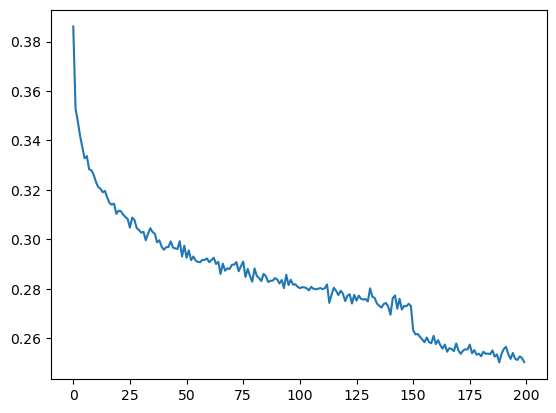

In [28]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [45]:
# # torch.arange(10).view(5, -1) # spread out into columns
# torch.arange(10).view(-1, 5) # spread out into rows

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [29]:
# put layers into eval mode (needed for batchnowm especially)
for layer in model.layers:
    layer.training = False

In [30]:
# evaluate the loss
@torch.no_grad() # this decorator disables the gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    # emb = C[x] # (N, block_size, n_embd)
    # x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    # for layer in layers:
    #     x = layer(x)

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7691240310668945
val 1.991478681564331


- former result (3 char context + 200 hidden neurons, 12k params)
train 1.9163435697555542
val 2.034247875213623

- newer result (8 char context + 200 hidden neurons, 22k params) -> Flat Consecutive
train 1.9036598205566406
val 2.0195140838623047

- newer result (with bug fix) (8 char context + 200 hidden neurons, 22k params) -> Flat Consecutive
train 1.908972978591919
val 2.0178210735321045

- newer result 8 char context + 128 hidden neurons, 76k params) -> Flat Consecutive
train 1.7691240310668945
val 1.991478681564331

In [31]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ....
    while True:
        # forward pass the neural net
        # emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        # x = emb.view(emb.shape[0], -1) # concantenate the vectors
        # for layer in layers:
        #     x = layer(x)
        # logits = x

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shidt the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

makayah.
nisha.
avisha.
yuvino.
madelynn.
matthewyn.
arniyah.
entlee.
kiara.
arjom.
saffreida.
ayo.
locen.
roberta.
nalia.
jossen.
cayeton.
mekadei.
joelle.
natania.


In [32]:
torch.zeros(3,4,2).view(3, 3//2, 2)

RuntimeError: shape '[3, 1, 2]' is invalid for input of size 24